# 🚀 Meter Anomaly Detection Pipeline
This notebook:
- Loads IoT water meter data
- Handles imbalance with SMOTE
- Trains a RandomForest classifier
- Logs experiments to MLflow with all relevant parameters & metrics
- Keeps `column_mapping` for Evidently


In [1]:
# 📦 Import libraries
import pandas as pd
import numpy as np
import os
import pickle
import json
import mlflow
import mlflow.pyfunc

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, roc_curve, auc
)

from imblearn.over_sampling import SMOTE
from mlflow.models.signature import infer_signature

from datetime import datetime
from typing import List, Tuple, Any


/opt/conda/lib/python3.11/site-packages/mlflow/__init__.py:41: UserWarning: Versions of mlflow (2.11.3) and mlflow-skinny (2.22.0) are different. This may lead to unexpected behavior. Please install the same version of both packages.
  mlflow.mismatch._check_version_mismatch()


# ⚙️ Configuration
- Set experiment name
- Control whether MLflow logging is active


In [2]:
EXPERIMENT_NAME = "DemoVersion1"
MLFLOW_LOGGING = True

# Set up MLflow experiment (creates if doesn't exist)
mlflow.set_experiment(EXPERIMENT_NAME)

<Experiment: artifact_location='s3://artifacts/137', creation_time=1752823097091, experiment_id='137', last_update_time=1752823097091, lifecycle_stage='active', name='DemoVersion1', tags={'mlflow.note.content': '', 'mlflow.source.git.url': ''}>

# 📥 Load Data
Load dataset using your existing `DatasetManager` helper.


In [3]:
from MLOpsDatasets.dataset_manager import DatasetManager
manager = DatasetManager()
df = manager.download('waterMeterDemoData_df.zip')
if df is None:
    raise ValueError("❌ Dataset could not be loaded.")
df.head()

,user key,datetime,meter reading,diff,part_of_day_Afternoon,part_of_day_Evening,part_of_day_Morning,part_of_day_Night,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,Cluster,Part of Day,Anomaly
0,394498ca-90e0-419a-bb06-f700ef43fa15,2016-06-30 21:34:42,211134.0,0.0,False,False,False,True,False,False,False,False,True,False,False,0,Night,0
1,394498ca-90e0-419a-bb06-f700ef43fa15,2016-06-30 20:34:42,211134.0,0.0,False,True,False,False,False,False,False,False,True,False,False,1,Evening,0
2,394498ca-90e0-419a-bb06-f700ef43fa15,2016-06-30 19:34:42,211134.0,0.0,False,True,False,False,False,False,False,False,True,False,False,1,Evening,0
3,394498ca-90e0-419a-bb06-f700ef43fa15,2016-06-30 18:34:42,211134.0,0.0,False,True,False,False,False,False,False,False,True,False,False,1,Evening,0
4,394498ca-90e0-419a-bb06-f700ef43fa15,2016-06-30 17:34:45,211134.0,0.0,False,True,False,False,False,False,False,False,True,False,False,1,Evening,0


# 🧬 Feature Engineering
- Add part of day column
- Label anomalies from clustering results


In [4]:
# Create part of day
conditions = [
    df['part_of_day_Afternoon'],
    df['part_of_day_Evening'],
    df['part_of_day_Morning'],
    df['part_of_day_Night']
]
choices = ['Afternoon', 'Evening', 'Morning', 'Night']
df['Part of Day'] = np.select(conditions, choices, default='Unknown')

# Label DBSCAN cluster -1 as anomalies
df['Anomaly'] = np.where(df['Cluster'] == -1, 1, 0)

# 🔬 Scale Features
Using StandardScaler for normalization.


In [5]:
features = [
    'diff',
    'part_of_day_Afternoon', 'part_of_day_Evening', 'part_of_day_Morning', 'part_of_day_Night',
    'day_of_week_Friday', 'day_of_week_Monday', 'day_of_week_Saturday',
    'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday'
]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

# 🏗️ Train/Test Split & Handle Imbalance with SMOTE

In [6]:
X_train, X_test, y_train, y_test, df_train, df_test = train_test_split(
    X_scaled,
    df['Anomaly'].values,
    df[['user key', 'datetime']],
    test_size=0.2,
    random_state=42
)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# 🚀 Train RandomForest Model

In [7]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X_train_res, y_train_res)
y_pred = rf_model.predict(X_test)

In [8]:
# Print evaluation scores
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9972
Precision: 0.6617
Recall: 0.9975
F1 Score: 0.7956


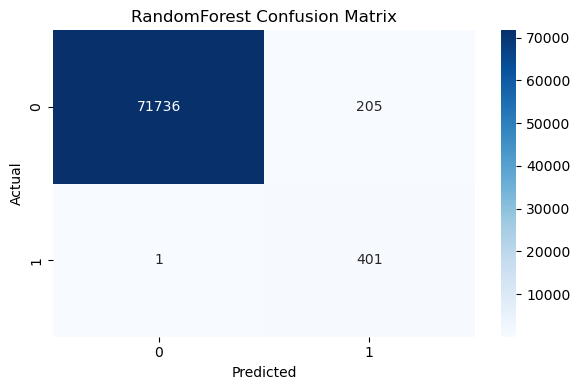

In [9]:
# Plot and show confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("RandomForest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

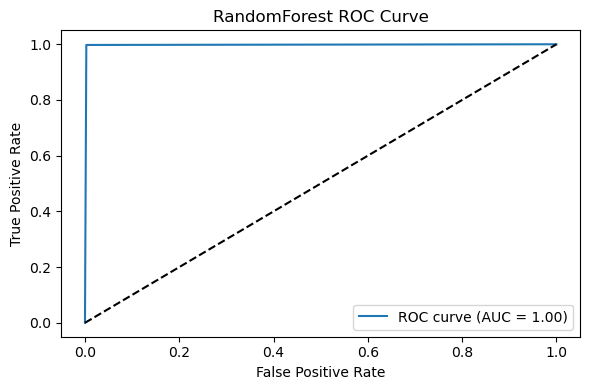

In [10]:
# Plot and show ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RandomForest ROC Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# 💾 Save Model & Scaler
To local disk, for reproducible serving & logging.

In [11]:
os.makedirs("./models/RandomForest", exist_ok=True)
pickle.dump(rf_model, open("./models/RandomForest/RandomForestClassifier.pkl", "wb"))
pickle.dump(scaler, open("./models/RandomForest/standard_scaler.pkl", "wb"))

# 📊 Prepare Reference Data for Evidently
We’ll use this for monitoring or MLflow artifacts.

In [12]:
df_train

,user key,datetime
119643,ab940a26-b759-4a38-84c8-6ed55cec638b,2016-06-19 20:19:52
77779,8badf844-b3c1-434f-9877-a0b1c852d15e,2016-03-16 12:12:02
226136,45e1b10b-b59e-4f99-b042-5cc77240b821,2016-02-15 13:45:17
158881,927a9043-e893-41c2-b368-33ce874ace98,2016-02-07 07:59:35
117989,79530fed-9e11-4302-80df-0c7365d55916,2016-02-29 22:27:40
...,...,...
119879,ab940a26-b759-4a38-84c8-6ed55cec638b,2016-06-09 16:20:05
259178,0c49020e-b677-429e-a7e4-c60b19774ca0,2016-04-29 01:20:14
131932,8b9a4ee9-5b24-4f21-a2f5-ee267d072c66,2016-01-02 20:13:26
146867,c84748e4-a9c2-40d1-8126-f21e48a686db,2016-01-30 14:44:16


In [13]:
# Split your original DataFrame (with all columns)
df_train, df_test, y_train, y_test = train_test_split(
    df,
    df['Anomaly'].values,
    test_size=0.2,
    random_state=42
)

# Build a clean reference DataFrame for monitoring
reference_df = df_train[['datetime', 'diff', 'part_of_day_Afternoon', 'part_of_day_Evening', 'part_of_day_Morning', 'part_of_day_Night', 'day_of_week_Friday', 'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday']].reset_index(drop=True)
reference_df['Anomaly'] = y_train
reference_df = df_train[features].reset_index(drop=True)
reference_df['Anomaly'] = y_train
reference_df.to_csv("./models/RandomForest/reference_data.csv", index=False)

# 🧩 MLflow PyFunc Wrapper
So we can reload scaler + model together for consistent inference.

In [14]:
class RFModelWrapper(mlflow.pyfunc.PythonModel):
    def load_context(self, context):
        self.scaler = pickle.load(open("./models/RandomForest/standard_scaler.pkl", "rb"))
        self.model = pickle.load(open("./models/RandomForest/RandomForestClassifier.pkl", "rb"))

    def predict(self, context, model_input):
        meter_readings = np.array([x[0] for x in model_input])
        diffs = np.array([x[1] for x in model_input])
        timestamps = [x[2] for x in model_input]

        hours, weekdays = [], []
        for ts in timestamps:
            dt = pd.to_datetime(ts)
            hours.append(dt.hour)
            weekdays.append(dt.weekday())

        hours, weekdays = np.array(hours), np.array(weekdays)

        part_of_day = np.zeros((len(hours), 4))
        part_of_day[(5 <= hours) & (hours < 12), 0] = 1
        part_of_day[(12 <= hours) & (hours < 17), 1] = 1
        part_of_day[(17 <= hours) & (hours < 21), 2] = 1
        part_of_day[(hours >= 21) | (hours < 5), 3] = 1

        day_of_week = np.eye(7)[weekdays]

        features_input = np.column_stack((diffs, part_of_day, day_of_week))  
        scaled = self.scaler.transform(features_input)
        preds = self.model.predict(scaled)
        return preds.tolist()

/opt/conda/lib/python3.11/site-packages/mlflow/pyfunc/utils/data_validation.py:186: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(


In [15]:
# 🔍 Test wrapper
tester = RFModelWrapper()
tester.load_context(None)
sample_inputs = list(zip(df['meter reading'].iloc[:5], df['diff'].iloc[:5], df['datetime'].iloc[:5]))
predictions = tester.predict(None, sample_inputs)
print("Sample predictions:", predictions)

Sample predictions: [0, 0, 0, 0, 0]


/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [16]:
# 🔍 Test wrapper
tester = RFModelWrapper()
tester.load_context(None)
sample_inputs = list(zip([1,100,10000,100000], [10,100,500,1000], df['datetime'].iloc[:4]))
predictions = tester.predict(None, sample_inputs)
print("Sample predictions:", predictions)

Sample predictions: [0, 0, 1, 1]


/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


# 🚀 Log Experiment to MLflow
- Logs model, hyperparams, metrics, confusion matrix, column mapping for Evidently.

/opt/conda/lib/python3.11/site-packages/mlflow/pyfunc/__init__.py:3224: UserWarning: An input example was not provided when logging the model. To ensure the model signature functions correctly, specify the `input_example` parameter. See https://mlflow.org/docs/latest/model/signatures.html#model-input-example for more details about the benefits of using input_example.
  color_warning(


Registered model 'DemoRandomForest' already exists. Creating a new version of this model...
2025/07/18 07:45:08 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: DemoRandomForest, version 2
Created version '2' of model 'DemoRandomForest'.


🏃 View run agreeable-flea-888 at: http://10.149.59.75:5000/#/experiments/137/runs/0210bb6f4b1b494f9780baf8430c4304
🧪 View experiment at: http://10.149.59.75:5000/#/experiments/137


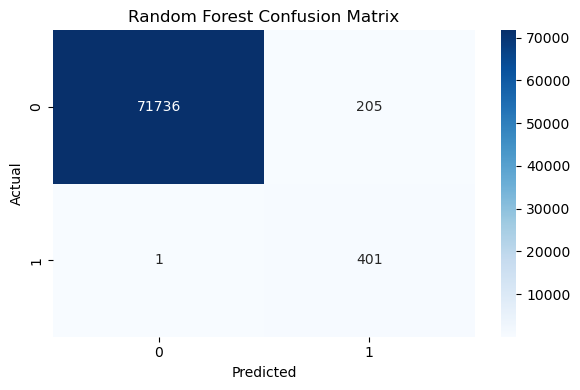

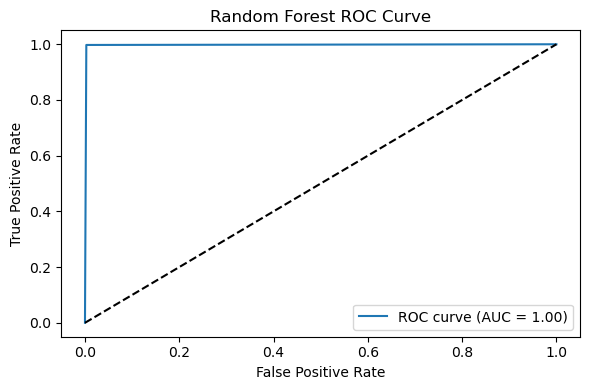

In [17]:
# 🚀 Log to MLflow
def log_experiment():
    with mlflow.start_run():
        mlflow.log_param("model_type", "RandomForest")
        mlflow.log_param("n_estimators", 100)
        mlflow.log_param("max_depth", 5)
        mlflow.log_param("smote", True)

        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("precision", prec)
        mlflow.log_metric("recall", rec)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("roc_auc", roc_auc)

        plt.figure(figsize=(6,4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title("Random Forest Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.tight_layout()
        plt.savefig("./models/RandomForest/confusion_matrix.png")
        mlflow.log_artifact("./models/RandomForest/confusion_matrix.png")

        plt.figure(figsize=(6,4))
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Random Forest ROC Curve')
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.savefig("./models/RandomForest/roc_curve.png")
        mlflow.log_artifact("./models/RandomForest/roc_curve.png")

        mlflow.log_artifact("./models/RandomForest/reference_data.csv")

        column_mapping = {
            "numerical_features": features,
            "categorical_features": [],
            "text_features": [],
            "input_features": features,
            "predicted_features": ["prediction"]
        }
        mlflow.log_param("column_mapping", json.dumps(column_mapping))

        signature = infer_signature(reference_df[features], rf_model.predict(scaler.transform(reference_df[features])))
        mlflow.pyfunc.log_model(
            artifact_path="model",
            python_model=RFModelWrapper(),
            artifacts={
                "standard_scaler": "./models/RandomForest/standard_scaler.pkl",
                "model": "./models/RandomForest/RandomForestClassifier.pkl"
            },
            registered_model_name="DemoRandomForest",
            signature=signature
        )

# ✅ Execute MLflow logging
if MLFLOW_LOGGING:
    log_experiment()

# ✅ Run MLflow Logging
"""
Only executes if MLFLOW_LOGGING is set to True.
"""

/opt/conda/lib/python3.11/site-packages/mlflow/pyfunc/__init__.py:3224: UserWarning: An input example was not provided when logging the model. To ensure the model signature functions correctly, specify the `input_example` parameter. See https://mlflow.org/docs/latest/model/signatures.html#model-input-example for more details about the benefits of using input_example.
  color_warning(


Registered model 'DemoRandomForest' already exists. Creating a new version of this model...
2025/07/18 07:45:18 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: DemoRandomForest, version 3
Created version '3' of model 'DemoRandomForest'.


🏃 View run gentle-swan-119 at: http://10.149.59.75:5000/#/experiments/137/runs/8e4111ec57754dd0a5a27afcb72d77f5
🧪 View experiment at: http://10.149.59.75:5000/#/experiments/137


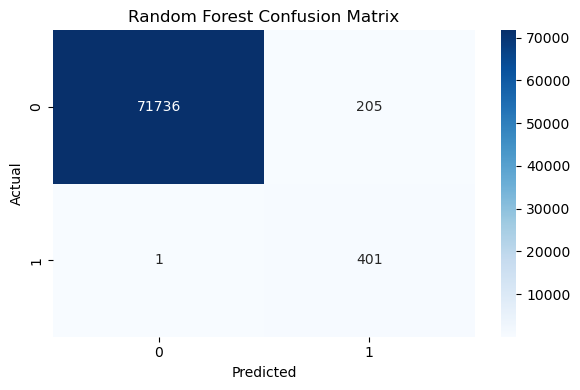

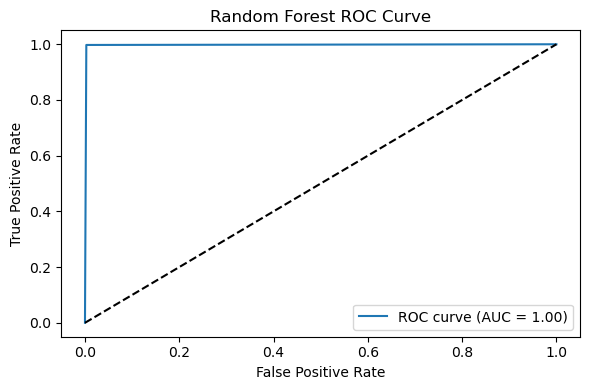

In [18]:
if MLFLOW_LOGGING:
    log_experiment()